## C19 data
- Meterological data source: http://www.aemet.es/es/datos_abiertos/AEMET_OpenData
- C19 data source: https://github.com/datadista/datasets/tree/master/COVID%2019

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime

## To read in the data
Unzip `data_C19.zip` in the directory of this notebook and run the cell below. This will load all dataframes into a dictionary with the name of the comunidad as key.

In [2]:
# Dictionary of weather stations used to obtain meterological data (Comunidad, Estacion).
sensor_dict = {
    "Andalucia"         : "5402" , # CORDOBA/AEROPUERTO
    "Aragon"            : "9434" , # ZARAGOZA/AEROPUERTO
    "Asturias"          : "1208H", # GIJON, MUSEL
    "Baleares"          : "B278" , # PALMA DE MALLORCA/SON SAN JUAN
    "Canarias"          : "C029O", # LANZAROTE/AEROPUERTO
    "Cantabria"         : "1111" , # SANTANDER I,CMT
    "Castilla-La Mancha": "4121" , # CIUDAD REAL
    "Castilla y Leon"   : "2422" , # VALLADOLID
    "Cataluna"          : "0016A", # REUS/AEROPUERTO
    "Ceuta"             : "5000C", # CEUTA
    "C. Valenciana"     : "8414A", # VALENCIA/AEROPUERTO
    "Extremadura"       : "3469A", # CACERES
    "Galicia"           : "1428" , # SANTIAGO DE COMPOSTELA/LABACOLLA
    "Madrid"            : "3200" , # MADRID/GETAFE
    "Melilla"           : "6000A", # MELILLA
    "Murcia"            : "7178I", # MURCIA
    "Navarra"           : "9263D", # PAMPLONA/NOAIN
    "Pais Vasco"        : "1024E", # SAN SEBASTIAN,IGUELDO
    "La Rioja"          : "9170"   # LOGRONO/AGONCILLO
}
df_comunidades = {}
 
for key in sensor_dict.keys():
    df_comunidades[key] = pd.read_csv("data/data_{}.csv".format(str(key)))
    df_comunidades[key].drop("Unnamed: 0", axis=1, inplace=True)
    df_comunidades[key]['fecha'] = pd.to_datetime(df_comunidades[key]['fecha'], format="%Y-%m-%d")

FileNotFoundError: File b'data/data_Andalucia.csv' does not exist

## Dataframe format
- `prec`: precipitation
- `sol`: insolation
- `tmax`, `tmed`, `tmin`: max, median, and min temperatures
- `ncases`: total number of reported cases
- `uci`: number of people in the UCI
- `fallecidos`: total number of deaths

**Note:** there may be some NaN values
- in the `uci` and `fallecidos` columns in the first few days, as for these days only `ncases` data was available
- in the `uci` column for several days 
- in the meterological data during the last few days, as the measurements often lag

We may have to switch meterological data source to get the most up-to-date data.

In [3]:
comunidad = list(df_comunidades.keys())[0]
df = df_comunidades[comunidad]
df

,fecha,prec,sol,tmax,tmed,tmin,ncases,uci,fallecidos,hospitalizados
0,2020-02-27,0.0,10.8,22.2,12.2,2.3,1,NaN,NaN,NaN
1,2020-02-28,0.0,9.5,23.9,14.8,5.7,6,NaN,NaN,NaN
2,2020-02-29,0.6,7.8,16.9,13.6,10.3,8,NaN,NaN,NaN
3,2020-03-01,1.3,7.4,18.1,14.0,9.9,12,NaN,NaN,NaN
4,2020-03-02,0.1,9.3,20.7,15.2,9.8,12,NaN,NaN,NaN
5,2020-03-03,0.0,6.8,17.6,11.8,6.1,13,NaN,0.0,NaN
6,2020-03-04,0.0,10.0,22.4,15.6,8.9,13,1.0,0.0,NaN
7,2020-03-05,0.0,7.1,19.0,12.3,5.6,12,1.0,0.0,NaN
8,2020-03-06,0.0,10.8,19.7,12.4,5.2,21,1.0,0.0,NaN
9,2020-03-07,0.0,10.1,20.4,11.2,2.0,27,NaN,0.0,NaN


Text(0.5, 1.0, 'Comunidad: Aragon')

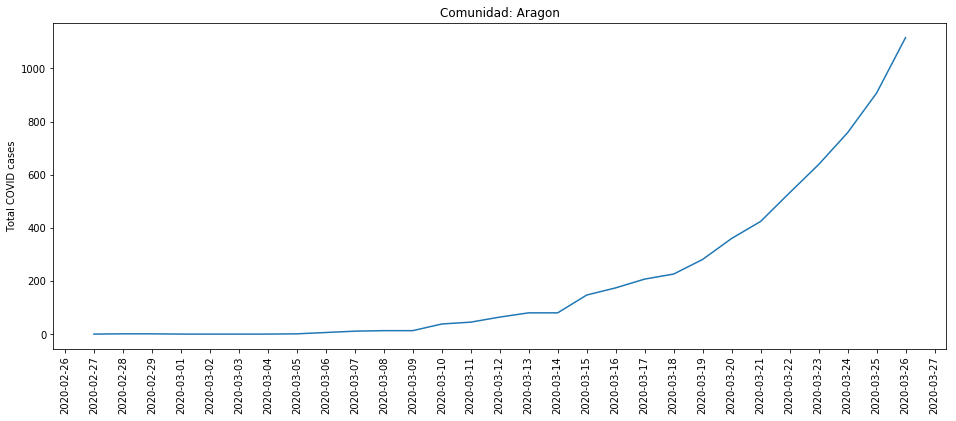

In [4]:
comunidad = list(df_comunidades.keys())[1]
df = df_comunidades[comunidad]

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

plt.plot(df.fecha,df['ncases'])
plt.xticks(rotation='vertical')

dloc = mdates.DayLocator()  # every day
plt.gca().xaxis.set_major_locator(dloc)
plt.ylabel('Total COVID cases')
plt.title("Comunidad: {}".format(comunidad))

---